# Интеллектуальный анализ данных – весна 2025

# Домашнее задание 7: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов.


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающие дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [3]:
n = 10
k = np.array([8, 2])
p = k/n

In [4]:
print(f'Энтропия: {np.round(-1 * np.dot(p, np.log(p)), 2)}')

Энтропия: 0.5


**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [5]:
def gini_coef(p : np.array) -> float:
    return np.sum(p * (1 - p))

p_l = np.array([1])
p_r = np.array([1])

print(f'Критерий информативности: {np.round(gini_coef(p) - p_l.size/p.size * gini_coef(p_l) - p_r.size/p.size * gini_coef(p_r), 2)}')

Критерий информативности: 0.32


**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [6]:
objs = [1, 10, 5, 18, 100, 30, 50, 61, 84, 47]
print(f'Предсказание будет средним значением целевой переменной на этих объектах: {np.mean(objs)}')

Предсказание будет средним значением целевой переменной на этих объектах: 40.6


## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [7]:
from collections import Counter
from typing import List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [8]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame], 
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух соседних (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов, len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`
    
    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    feature_vector = np.asarray(feature_vector)
    target_vector = np.asarray(target_vector)

    if feature_type == "real":

        sorted_indexes = np.argsort(feature_vector)
        feature_sorted = feature_vector[sorted_indexes]
        target_sorted = target_vector[sorted_indexes]

        valid = np.where(feature_sorted[:-1] != feature_sorted[1:])[0]
        if valid.size == 0:
            return np.array([]), np.array([]), None, None

        thresholds = (feature_sorted[valid] + feature_sorted[valid + 1]) / 2

        m = len(target_sorted)

        if task == "classification":
            classes, target_encoded = np.unique(target_sorted, return_inverse=True)
            target_one_hot = np.eye(len(classes))[target_encoded]

            cum_sum_left = np.cumsum(target_one_hot, axis=0)[:-1]
            total = cum_sum_left[-1]

            size_left = np.arange(1, m)[:, None]
            size_right = m - size_left

            p_left = cum_sum_left / size_left
            p_right = (total - cum_sum_left) / size_right

            gini_parent = np.sum(total / m * (1 - (total / m)))
            gini_left = np.sum(p_left * (1 - p_left), axis=1)
            gini_right = np.sum(p_right * (1 - p_right), axis=1)

            ginis = gini_parent - (size_left.ravel() * gini_left + size_right.ravel() * gini_right) / m

        elif task == "regression":
            cum_sum_target = np.cumsum(target_sorted)[:-1]
            target_squared = target_sorted ** 2
            cum_sum_target_squared = np.cumsum(target_squared)[:-1]

            size_left = np.arange(1, m)
            size_right = m - size_left

            var_left = cum_sum_target_squared / size_left - (cum_sum_target / size_left) ** 2
            var_right = (np.sum(target_squared) - cum_sum_target_squared) / size_right - ((np.sum(target_sorted) - cum_sum_target) / size_right) ** 2

            ginis = np.var(target_sorted) - (size_left * var_left + size_right * var_right) / m

        else:
            raise ValueError("task must be 'classification' or 'regression'")

        ginis = ginis[valid]
        best_index = np.argmax(ginis)

        return thresholds, ginis, thresholds[best_index], ginis[best_index]

    elif feature_type == "categorical":
        categories = np.unique(feature_vector)
        if len(categories) == 1:
            return np.array([]), np.array([]), None, None

        ginis = []
        thresholds = []

        for cat in categories:
            mask_left = feature_vector == cat
            mask_right = ~mask_left

            target_left = target_vector[mask_left]
            target_right = target_vector[mask_right]

            if len(target_left) == 0 or len(target_right) == 0:
                continue

            if task == "classification":
                def gini(target):
                    _, counts = np.unique(target, return_counts=True)
                    p = counts / counts.sum()
                    return np.sum(p * (1 - p))
                q = gini(target_vector) - (len(target_left)  * gini(target_left) + len(target_right) * gini(target_right)) / len(target_vector)

            elif task == "regression":
                q = np.var(target_vector) - (len(target_left) * np.var(target_left) + len(target_right) * np.var(target_right)) / len(target_vector)

            else:
                raise ValueError("task must be 'classification' or 'regression'")

            thresholds.append(cat)
            ginis.append(q)

        if len(ginis) == 0:
            return np.array([]), np.array([]), None, None

        ginis = np.array(ginis)
        thresholds = np.array(thresholds)

        best_index = np.argmax(ginis)

        return thresholds, ginis, thresholds[best_index], ginis[best_index]

    else:
        raise ValueError("feature_type must be 'real' or 'categorical'")

Эту функцию можно протестировать на датасете `California`.

In [9]:
from sklearn.datasets import fetch_california_housing

In [10]:
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [11]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894], shape=(20640,))

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`.

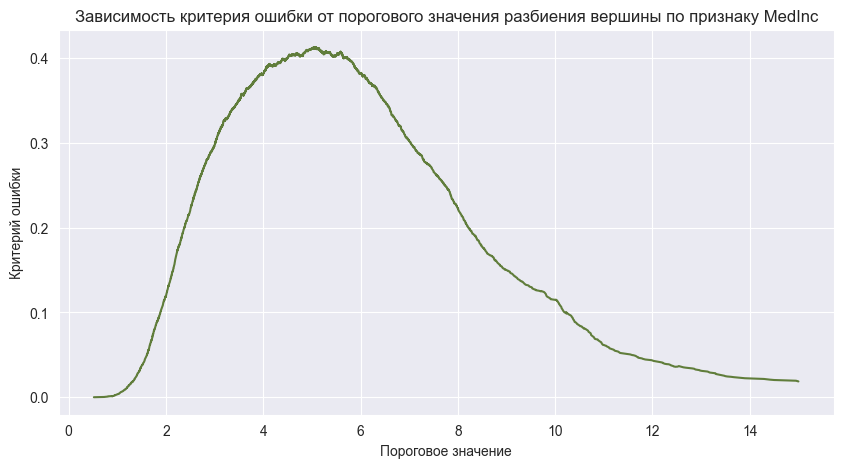

In [12]:
thresholds, ginis, _, _ = find_best_split(feature_vector=X['MedInc'], target_vector=y, task="regression", feature_type="real")
plt.figure(figsize=(10, 5))
plt.plot(thresholds, ginis, color="#607D3B")
plt.title("Зависимость критерия ошибки от порогового значения разбиения вершины по признаку MedInc")
plt.xlabel("Пороговое значение")
plt.ylabel("Критерий ошибки")
plt.grid(True)
plt.show()

Найдите лучший, с вашей точки зрения, предикат первой вершины решающего дерева.

In [13]:
best_feature = None
best_threshold = None
best_score = -np.inf

for feature in X.columns:
    _, _, best_threshhold_tmp, best_score_tmp = find_best_split(feature_vector=X[feature], target_vector=y, task="regression", feature_type="real")

    if best_threshhold_tmp is not None and best_score < best_score_tmp:
        best_feature = feature
        best_threshold = best_threshhold_tmp
        best_score = best_score_tmp

print(f"Лучший предикат: {best_feature} <= {best_threshold} (критерий ошибки: {best_score})")

Лучший предикат: MedInc <= 5.03515 (критерий ошибки: 0.4127513862016845)


**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

В задаче также предлагается получить два бонуса, по баллу на каждый!

- **Реализуйте способ обрабатывать пропуски в даннх и реализуйте его, пояснив свои действия.**
- **Реализуйте метод оценки важности признаков.**

In [14]:
class DecisionTree:
    
    def __init__(
        self, 
        feature_types: Union[List[str], np.ndarray], 
        max_depth: int = None, 
        min_samples_split: int = None, 
        min_samples_leaf: int = None,
        task: str = "classification",
        impute_strategy: str = "error"
    ) -> None:
        
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}
        
        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types
        
        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task
        
        # переменная для хранения важности признаков
        self._feature_importances = Counter()

        # тип импутации
        self._impute_strategy = impute_strategy

    def _prepare_data(self, X: np.ndarray, strategy: str) -> np.ndarray:
        """
        В зависимости от выбранной стратегии делает следующее:
        1) "error" - вернет ошибку при присутсвии пропуска, если запустить эту процедуру с такой стратегией, то она вернет полученный X
        2) "skip" - просто убирает все пропуски
        3) "fill" - заполняет пропуски: для real — медианой, для categorical — модой
        """
        if strategy == "error":
            if not np.isnan(X).any():
                return X
            raise ValueError("There is NaN values in X, and strategy set to error, so you can't fit or prepare data.")
        
        elif strategy == "skip":
            X_imp = X.copy().astype(object)
            mask = np.ones(X.shape[0], dtype=bool)

            for i in range(X.shape[1]):
                col = X_imp[:, i]
                col_mask = np.array([v is not None and (not isinstance(v, float) or not np.isnan(v)) for v in col])
                mask &= col_mask

            return X_imp[mask].astype(float)

        elif strategy == "fill":
            X_imp = X.copy().astype(object)
            n_features = X_imp.shape[1]
            for i in range(n_features):
                col = X_imp[:, i]
                # определяем маску пропусков
                mask = np.array([v is None or (isinstance(v, float) and np.isnan(v)) for v in col])
                if np.any(mask):
                    if self._feature_types[i] == "real":
                        vals = col[~mask].astype(float)
                        fill = np.median(vals) # будем заполнять медианой
                    else:
                        vals = col[~mask]
                        fill = Counter(vals).most_common(1)[0][0] # выбираем самый часто встречающийся и заполняем все им
                    col[mask] = fill
                    X_imp[:, i] = col
            return X_imp.astype(float)
        
        else:
            raise ValueError
        
    def _fit_node(
        self, 
        sub_X: np.ndarray, 
        sub_y: np.ndarray, 
        node: dict
    ) -> None:
        
        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]
            else:
                raise ValueError("Unknown feature type")

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)

            if gini is not None and (gini_best is None or gini > gini_best):
                feature_best = feature
                gini_best = gini

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = feature_vector < threshold_best
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    split = feature_vector == threshold
                else:
                    raise ValueError

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"
        self._feature_importances[feature_best] += gini # как важность прибавляем коэффициент Джини

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError
            
        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        if node["type"] == "terminal":
            return node["class"]
        
        if self._feature_types[node["feature_split"]] == "categorical":
            if x[node["feature_split"]] == node["category_split"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])

        elif self._feature_types[node["feature_split"]] == "real":
            if x[node["feature_split"]] < node["threshold"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])
            
        else:
            raise ValueError("feature_type must be 'categorical' ot 'real'")

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        # подготовим сначала данные, оброботав пропуски пропуски
        X_imp = self._prepare_data(X, self._impute_strategy)
        self._fit_node(X_imp, y, self._tree)
        # после построения нормируем важности
        total = sum(self._feature_importances.values())
        if total > 0:
            for k in self._feature_importances:
                self._feature_importances[k] /= total

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
            
        return np.array(predicted)
    
    @property
    def feature_importance_(self) -> np.ndarray:
        fi = np.zeros(len(self._feature_types))
        for k, v in self._feature_importances.items():
            fi[k] = v
        return fi

**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

In [15]:
df = pd.read_csv("students.csv")
df.sample(5)

,Unnamed: 0,STG,SCG,STR,LPR,PEG,UNS
18,18,0.150,0.32,0.05,0.27,0.29,0
85,85,0.248,0.30,0.31,0.20,0.03,0
235,235,0.580,0.35,0.51,0.27,0.30,0
10,10,0.180,0.18,0.55,0.30,0.81,1
198,198,0.780,0.15,0.38,0.18,0.63,1


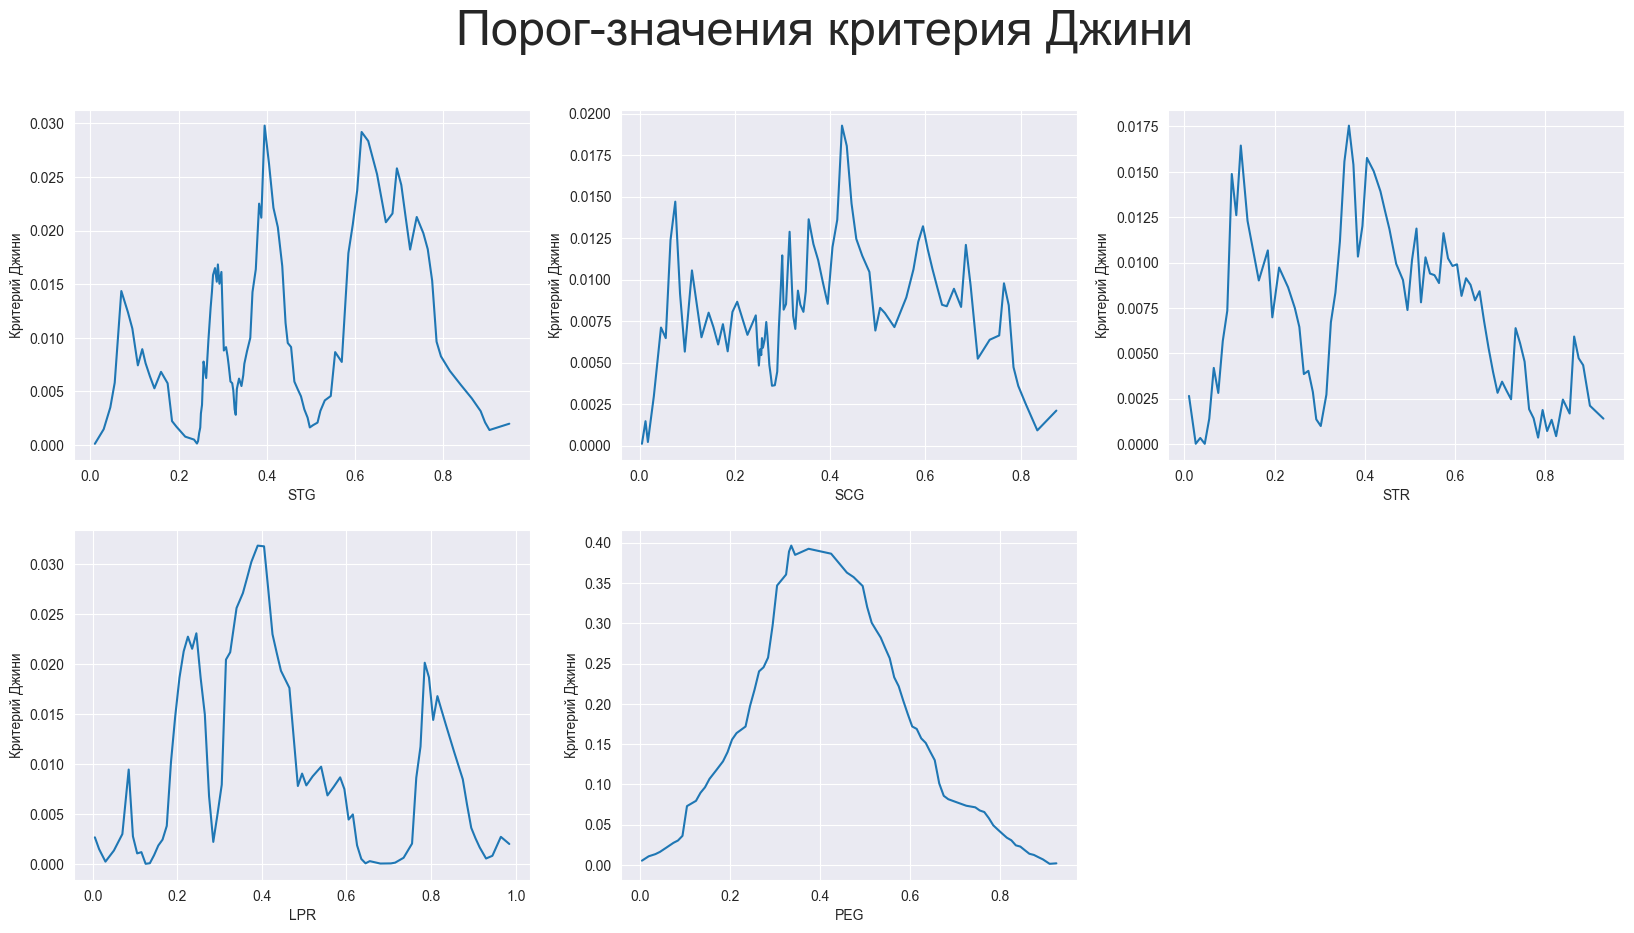

In [16]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10))
plt.suptitle("Порог-значения критерия Джини", size=35)
for i in range(1, 6):
    t, g, _, _ = find_best_split(feature_vector=df.iloc[:, i], target_vector=df.iloc[:, 6], task="classification", feature_type="real")
    row, col = divmod(i - 1, 3)
    ax[row, col].plot(t, g)
    ax[row, col].set_xlabel(df.keys()[i])
    ax[row, col].set_ylabel("Критерий Джини")
    ax[row, col].grid(True)
ax.flat[5].axis("off")
plt.show()

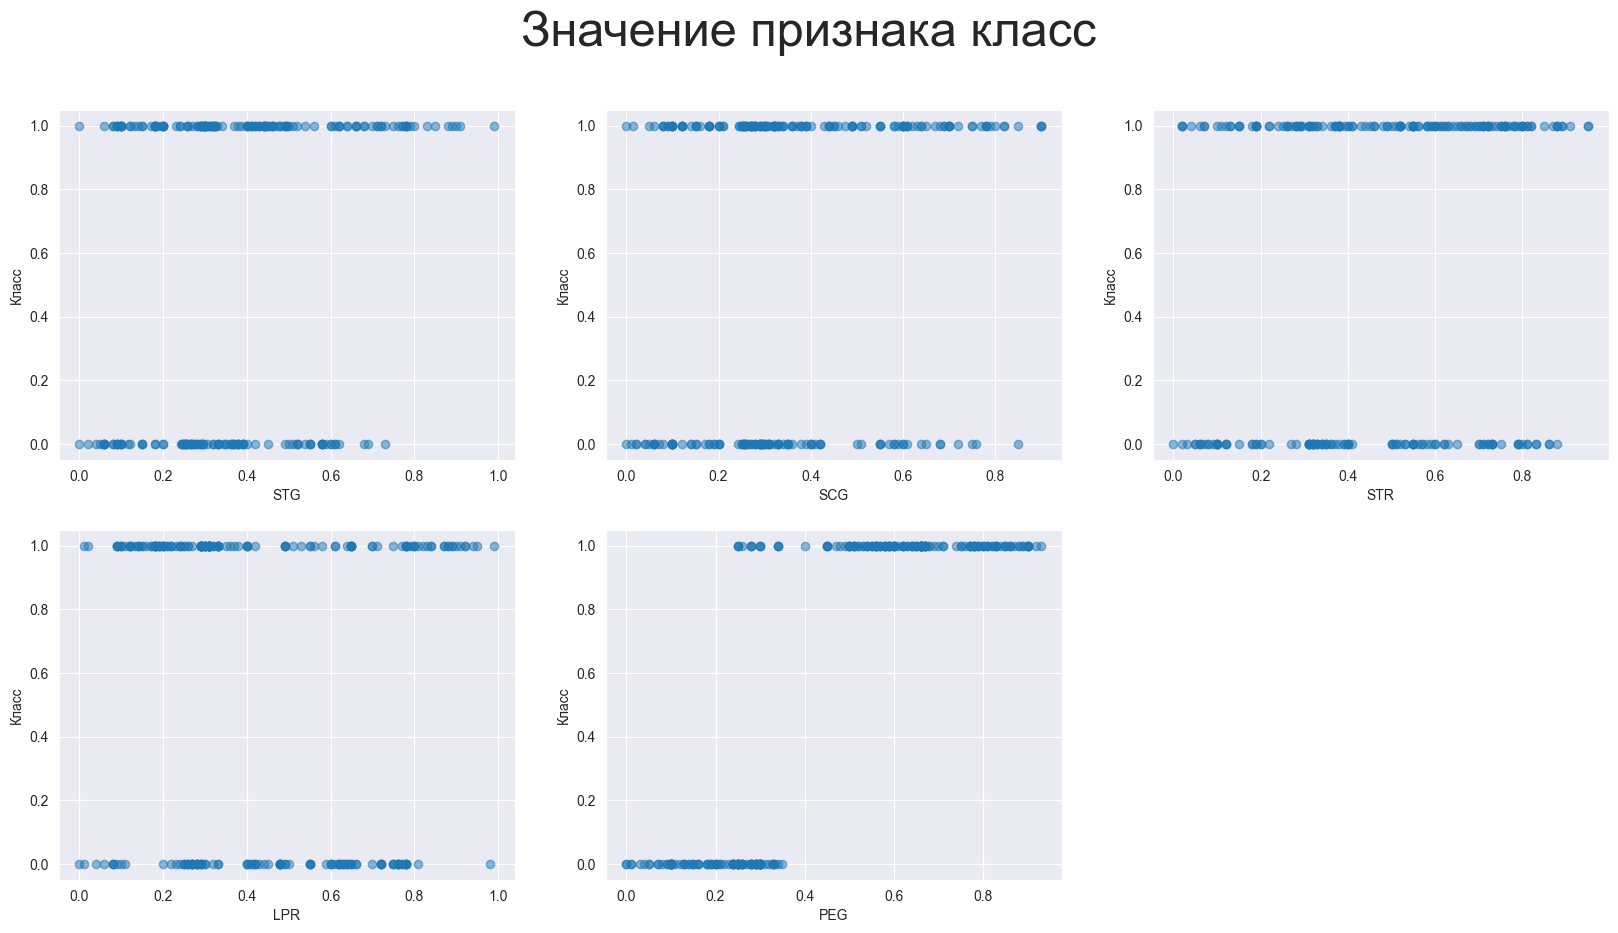

In [17]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10))
plt.suptitle("Значение признака класс", size=35)
for i in range(1, 6):
    row, col = divmod(i - 1, 3)
    ax[row, col].scatter(df.iloc[:, i], df.iloc[:, 6], alpha=0.5)
    ax[row, col].set_xlabel(df.keys()[i])
    ax[row, col].set_ylabel("Класс")
    ax[row, col].grid(True)
ax.flat[5].axis("off")
plt.show()

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

Ответ: Исходя из кривых значений критерия Джини производить разделения стоит по признаку PEG. Это  согласуется с диаграммами рассеяиния, так как видно, что по PEG данные почти полностью верно разделяются (PEG>0.4 почти все объекты относятся к классу один и при PEG<=0.4 - ноль). Хороший вид кривой - кривая с четким единственным максимумом, которая сначала растет, а затем убывает, так же этот максимум должен быть близок к 0.5 ну или больше. Кривые, деление по которым невозможно сделать деление, содержат много максимумов и/или максимумы маленькие.

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). 

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), 
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа. 

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [18]:
data = pd.read_csv("agaricus-lepiota.data")
data.sample(5)

,p,x,s,n,t,p.1,f,c,n.1,k,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
7804,p,x,y,n,f,m,f,c,b,w,...,y,c,c,p,w,n,n,w,c,d
4115,p,x,f,y,f,f,f,c,b,g,...,k,n,n,p,w,o,l,h,v,d
2456,e,x,f,g,t,n,f,c,b,p,...,s,w,w,p,w,o,p,n,v,d
7356,p,k,s,e,f,f,f,c,n,b,...,s,p,p,p,w,o,e,w,v,l
5090,p,x,y,g,f,f,f,c,b,p,...,k,p,b,p,w,o,l,h,v,p


In [19]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score

In [20]:
le = LabelEncoder()
data_encoded = data.apply(le.fit_transform)

In [21]:
X = data_encoded.drop(columns=["p"])
y = data_encoded["p"]

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

In [23]:
tree = DecisionTree(feature_types=["categorical" for i in range(X_train.shape[1])])

tree.fit(np.array(X_train), np.array(y_train))
accuracy_train = accuracy_score(tree.predict(np.array(X_train)), y_train)
accuracy_test = accuracy_score(tree.predict(np.array(X_test)), y_test)
print(f'Доля правильных ответов на обучающем наборе: {accuracy_train}, на тестовом наборе: {accuracy_test}')

Доля правильных ответов на обучающем наборе: 1.0, на тестовом наборе: 0.999507631708518


## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [24]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [25]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

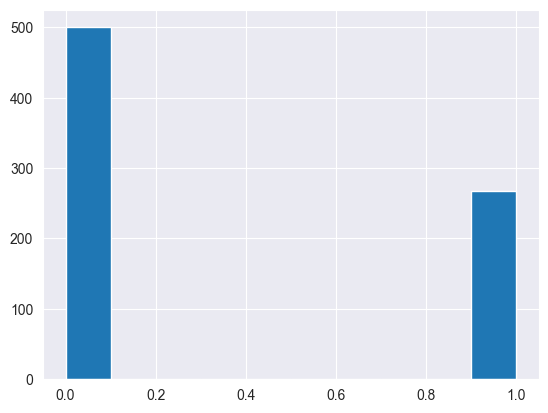

In [26]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [27]:
X = data.drop(columns=["Outcome"])
y = data["Outcome"]
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.3, random_state=0)

**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке. 


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [28]:
max_depth_values = [2, 3, 4, 5, 6, 8, 10, 12, 16, 20]
min_samples_leaf_values = [1, 2, 5, 10, 20, 25, 30]

best_f1 = -1
best_params = None

for max_depth in max_depth_values:
    for min_samples_leaf in min_samples_leaf_values:
        dtc = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=0)
        dtc.fit(X_train, y_train)
        f1 = f1_score(y_val, dtc.predict(X_val))
        if f1 > best_f1:
            best_f1 = f1
            best_params = (max_depth, min_samples_leaf)

print("Лучшие параметры:", best_params, "F1:", best_f1)

Лучшие параметры: (4, 25) F1: 0.6666666666666666


In [29]:
dtc = DecisionTreeClassifier(max_depth=best_params[0], min_samples_leaf=best_params[1], random_state=0)
dtc.fit(X_train_full, y_train_full)
y_pred = dtc.predict(X_test)
y_pred_proba = dtc.predict_proba(X_test)[:, 1]
print(f'Доля верных ответов: {accuracy_score(y_test, y_pred)}, \n'
      f'Точность: {precision_score(y_test, y_pred)}, \n'
      f'Полнота: {recall_score(y_test, y_pred)}, \n'
      f'AUC-ROC: {roc_auc_score(y_test, y_pred_proba)}, \n')

Доля верных ответов: 0.7489177489177489, 
Точность: 0.6212121212121212, 
Полнота: 0.5540540540540541, 
AUC-ROC: 0.8072818040970907, 



**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [30]:
bc = BaggingClassifier(n_estimators=50, random_state=0)
bc.fit(X_train_full, y_train_full)
y_pred = bc.predict(X_test)
y_pred_proba = bc.predict_proba(X_test)[:, 1]
print(f'Доля верных ответов: {accuracy_score(y_test, y_pred)}, \n'
      f'Точность: {precision_score(y_test, y_pred)}, \n'
      f'Полнота: {recall_score(y_test, y_pred)}, \n'
      f'AUC-ROC: {roc_auc_score(y_test, y_pred_proba)}, \n')

Доля верных ответов: 0.7792207792207793, 
Точность: 0.6885245901639344, 
Полнота: 0.5675675675675675, 
AUC-ROC: 0.8161473575486313, 



**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации. 
3. Выберите ту пару значений, которая даёт наилучшее среднее качество. 

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [31]:
from sklearn.model_selection import cross_val_score

In [32]:
max_depth_values = [3, 5, 7, 10, 15, 20 , 25]
min_samples_split_values = [2, 5, 10]
best_score = -1
best_params = None

for max_depth in max_depth_values:
    for min_samples_split in min_samples_split_values:
        clf = RandomForestClassifier(
            n_estimators=50,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            random_state=0,
            n_jobs=-1
        )
        scores = cross_val_score(
            clf,
            X_train_full,
            y_train_full,
            cv=5,
            scoring="f1"
        )
        mean_score = np.mean(scores)
        if mean_score > best_score:
            best_score = mean_score
            best_params = (max_depth, min_samples_split)

print("Лучшие параметры:", best_params, "F1:", best_score)

Лучшие параметры: (15, 5) F1: 0.6325335332705575


In [33]:
rf = RandomForestClassifier(
    n_estimators=50,
    max_depth=best_params[0],
    min_samples_split=best_params[1],
    random_state=0,
    n_jobs=-1
)
rf.fit(X_train_full, y_train_full)
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)[:, 1]
print(f'Доля верных ответов: {accuracy_score(y_test, y_pred)}, \n'
      f'Точность: {precision_score(y_test, y_pred)}, \n'
      f'Полнота: {recall_score(y_test, y_pred)}, \n'
      f'AUC-ROC: {roc_auc_score(y_test, y_pred_proba)}, \n')

Доля верных ответов: 0.7922077922077922, 
Точность: 0.7166666666666667, 
Полнота: 0.581081081081081, 
AUC-ROC: 0.8299621277328284, 



По всем рассмотренным метрикам RandomForest оказался лучше.

**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

In [34]:
n_estimators_list = [10, 20, 50, 75, 100, 150, 200, 300, 500, 700, 1000]
auc_roc_list_train = []
auc_roc_list_test = []

for n in n_estimators_list:
    clf = RandomForestClassifier(
        n_estimators=n,
        max_depth=best_params[0],
        min_samples_split=best_params[1],
        random_state=0,
        n_jobs=-1
    )
    clf.fit(X_train_full, y_train_full)
    y_pred_proba_train = clf.predict_proba(X_train_full)[:, 1]
    auc_roc_list_train.append(roc_auc_score(y_train_full, y_pred_proba_train))
    y_pred_proba_test = clf.predict_proba(X_test)[:, 1]
    auc_roc_list_test.append(roc_auc_score(y_test, y_pred_proba_test))

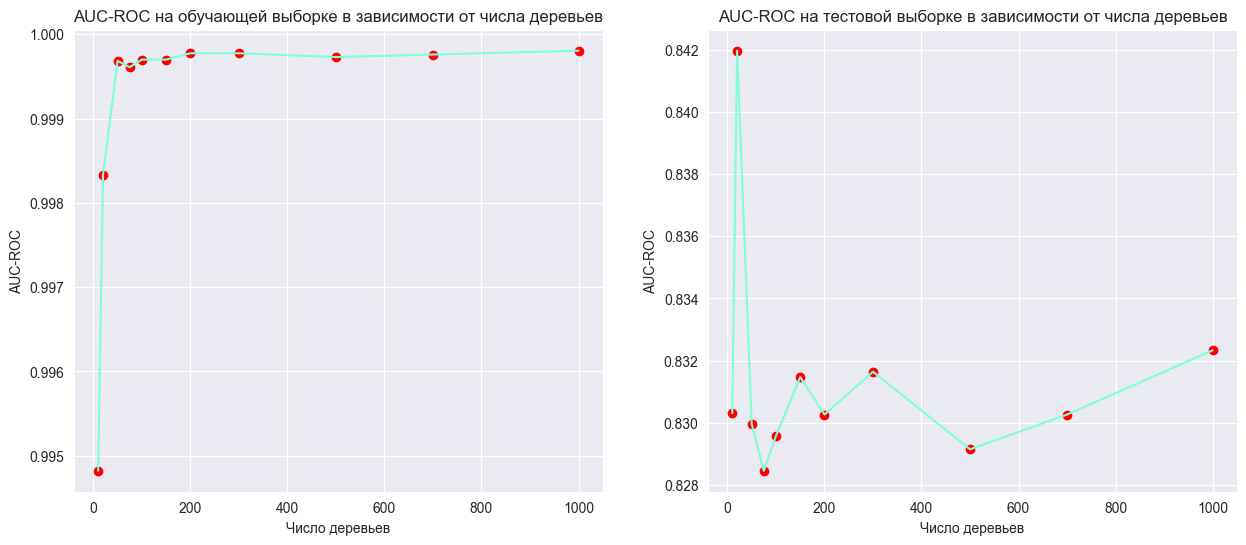

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
ax[0].plot(n_estimators_list, auc_roc_list_train, color='aquamarine')
ax[0].scatter(n_estimators_list, auc_roc_list_train, color='red')
ax[0].set_title("AUC-ROC на обучающей выборке в зависимости от числа деревьев")
ax[0].set_xlabel('Число деревьев')
ax[0].set_ylabel('AUC-ROC')
ax[0].grid(True)
ax[1].plot(n_estimators_list, auc_roc_list_test, color='aquamarine')
ax[1].scatter(n_estimators_list, auc_roc_list_test, color='red')
ax[1].set_title("AUC-ROC на тестовой выборке в зависимости от числа деревьев")
ax[1].set_xlabel('Число деревьев')
ax[1].set_ylabel('AUC-ROC')
ax[1].grid(True)
plt.show()

Сначала AUC-ROC растет, но при дальнейшем увеличении, начиная с какого-то момента, количества деревьев AUC-ROC не увеличивается, то есть при добавлении деревьев модель не переобучается. В начале на тестовой выборке есть выброс, но он не значительный на 0.1. Можно еще заметить, что в этом случае AUC-ROC вообще сильно не меняется в зависимости от количества деревьев.

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

In [36]:
import seaborn as sns

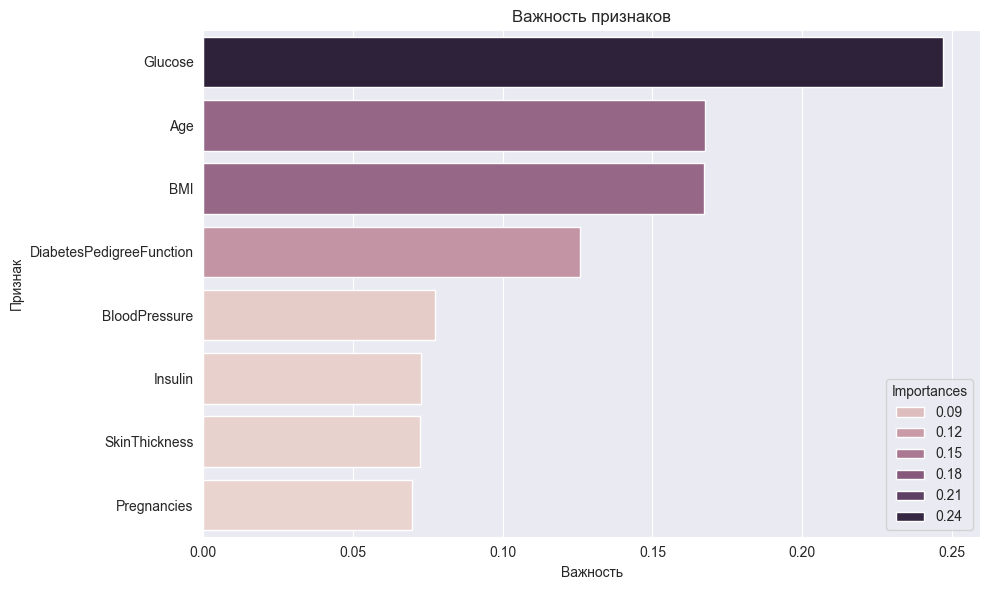

In [37]:
importances = rf.feature_importances_
features_names = X_train_full.columns
features_importances = pd.DataFrame(
    {
        "Features": features_names,
        "Importances": importances
    }
).sort_values(by="Importances", ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(data=features_importances, x="Importances", y="Features", hue="Importances")
plt.title('Важность признаков')
plt.xlabel('Важность')
plt.ylabel('Признак')
plt.tight_layout()
plt.show()

В итоге самым важным признаком для RandomForest оказался Glucose (видимо кол-во глюкозы в крови), что в принципе очень логично.